In [95]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import os
from ament_index_python import get_package_share_directory
from datetime import datetime

In [96]:
def load_yaml(filename):
    pkg_name = 'rover_controller'
    path_pkg_share_path = get_package_share_directory(pkg_name)
    ws_path, _ = path_pkg_share_path.split('install')
    # filename = 'odom_0.8.yaml'
    yaml_path = os.path.join(ws_path, 'src', pkg_name, 'data', filename)
    with open(yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

In [97]:
def plot_data_and_calcurate_error(data):
    gt_x, gt_y, vo_x, vo_y = [], [], [], []

    # === Extract points ===
    for entry in data['synchronized_data']:
        gt = entry['ground_truth']
        vo = entry['visual_odom']
        gt_x.append(gt['x'])
        gt_y.append(gt['y'])
        vo_x.append(vo['x'])
        vo_y.append(vo['y'])

    # === Convert to NumPy arrays for error metrics ===
    gt_x = np.array(gt_x)
    gt_y = np.array(gt_y)
    vo_x = np.array(vo_x)
    vo_y = np.array(vo_y)

    # === Calculate RMSE ===
    rmse = np.sqrt(np.mean((gt_x - vo_x)**2 + (gt_y - vo_y)**2))

    # === Calculate Percentage Error ===
    total_gt_dist = np.sum(np.sqrt(np.diff(gt_x)**2 + np.diff(gt_y)**2))
    total_error_dist = np.sum(np.sqrt((gt_x - vo_x)**2 + (gt_y - vo_y)**2))
    percentage_error = (total_error_dist / total_gt_dist) * 100 if total_gt_dist > 0 else 0

    # === Print Metrics ===
    # print(f"RMSE: {rmse:.4f} m")
    # print(f"Total Path Error: {total_error_dist:.4f} m")
    # print(f"Percentage Error: {percentage_error:.2f}%")

    # === Plot ===
    plt.figure(figsize=(6, 4))
    plt.plot(gt_x, gt_y, label='Ground Truth', linestyle='-', color='blue')
    plt.plot(vo_x, vo_y, label='Visual Odometry', linestyle='--', color='red')
    plt.title('Trajectory Comparison')
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [98]:
def calculate_rmse(data):
    synchronized_data = data['synchronized_data']

    if len(synchronized_data) < 2:
        print('Not enough data points for RMSE calculation')
        return
        
    # Extract coordinates
    gt_x = np.array([point['ground_truth']['x'] for point in synchronized_data])
    gt_y = np.array([point['ground_truth']['y'] for point in synchronized_data])
    vo_x = np.array([point['visual_odom']['x'] for point in synchronized_data])
    vo_y = np.array([point['visual_odom']['y'] for point in synchronized_data])

    # Calculate distances from origin for each point
    gt_distances = np.sqrt(gt_x**2 + gt_y**2)
    vo_distances = np.sqrt(vo_x**2 + vo_y**2)

    # Calculate position errors
    position_errors = np.sqrt((gt_x - vo_x)**2 + (gt_y - vo_y)**2)

    # Calculate RMSE
    rmse = np.sqrt(np.mean(position_errors**2))

    # Calculate percentage error
    # Method 1: RMSE as percentage of mean ground truth distance
    mean_gt_distance = np.mean(gt_distances)
    percent_error_rmse = (rmse / mean_gt_distance) * 100 if mean_gt_distance > 0 else 0

    # Method 2: Mean percentage error for each point
    individual_percent_errors = []
    for i in range(len(gt_distances)):
        if gt_distances[i] > 0:
            percent_err = (position_errors[i] / gt_distances[i]) * 100
            individual_percent_errors.append(percent_err)

    mean_percent_error = np.mean(individual_percent_errors) if individual_percent_errors else 0

    # Calculate additional statistics
    max_error = np.max(position_errors)
    min_error = np.min(position_errors)
    std_error = np.std(position_errors)

    # Log detailed results
    print('=== RMSE Analysis Results ===')
    print(f'Total data points: {len(synchronized_data)}')
    print(f'RMSE: {rmse:.4f} meters')
    print(f'Max error: {max_error:.4f} meters')
    print(f'Min error: {min_error:.4f} meters')
    print(f'Std deviation: {std_error:.4f} meters')
    print(f'Mean GT distance: {mean_gt_distance:.4f} meters')
    print(f'Percentage error (RMSE/mean_dist): {percent_error_rmse:.2f}%')
    print(f'Mean individual percentage error: {mean_percent_error:.2f}%')
    print('============================')

### Plot Error Analysis

In [99]:
def plot_error_analysis( synchronized_data, timestamp):
    """Create detailed error analysis plots"""
    # Extract coordinates
    gt_x = np.array([point['ground_truth']['x'] for point in synchronized_data])
    gt_y = np.array([point['ground_truth']['y'] for point in synchronized_data])
    vo_x = np.array([point['visual_odom']['x'] for point in synchronized_data])
    vo_y = np.array([point['visual_odom']['y'] for point in synchronized_data])
    
    # Calculate errors
    position_errors = np.sqrt((gt_x - vo_x)**2 + (gt_y - vo_y)**2)
    x_errors = gt_x - vo_x  # Signed errors
    y_errors = gt_y - vo_y  # Signed errors
    
    # Create figure for error analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Detailed Error Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Error Histogram
    axes[0, 0].hist(position_errors, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(np.mean(position_errors), color='red', linestyle='--', 
                        label=f'Mean: {np.mean(position_errors):.4f}m')
    axes[0, 0].axvline(np.median(position_errors), color='orange', linestyle='--', 
                        label=f'Median: {np.median(position_errors):.4f}m')
    axes[0, 0].set_xlabel('Position Error (m)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Position Error Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: X vs Y Error Scatter
    axes[0, 1].scatter(x_errors, y_errors, alpha=0.6, c=position_errors, cmap='viridis')
    axes[0, 1].axhline(0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].axvline(0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].set_xlabel('X Error (m)')
    axes[0, 1].set_ylabel('Y Error (m)')
    axes[0, 1].set_title('X vs Y Error Distribution')
    cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
    cbar.set_label('Position Error (m)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Cumulative Error
    cumulative_error = np.cumsum(position_errors)
    axes[1, 0].plot(range(len(cumulative_error)), cumulative_error, 'purple', linewidth=2)
    axes[1, 0].set_xlabel('Sample Index')
    axes[1, 0].set_ylabel('Cumulative Error (m)')
    axes[1, 0].set_title('Cumulative Position Error')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Error Statistics Box Plot
    error_data = [x_errors, y_errors, position_errors]
    labels = ['X Error', 'Y Error', 'Position Error']
    box_plot = axes[1, 1].boxplot(error_data, labels=labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    axes[1, 1].set_ylabel('Error (m)')
    axes[1, 1].set_title('Error Statistics')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    
    # Save the error analysis plot
    error_plot_filename = f'plots/error_analysis_{timestamp}.png'
    plt.savefig(error_plot_filename, dpi=300, bbox_inches='tight')
    print(f'Error analysis plot saved to: {error_plot_filename}')
    
    plt.close()

### Plot Trajectories

In [100]:
def plot_trajectories( synchronized_data):
    """Create comparison plots of ground truth vs visual odometry trajectories"""
    try:
        # Extract coordinates
        gt_x = np.array([point['ground_truth']['x'] for point in synchronized_data])
        gt_y = np.array([point['ground_truth']['y'] for point in synchronized_data])
        vo_x = np.array([point['visual_odom']['x'] for point in synchronized_data])
        vo_y = np.array([point['visual_odom']['y'] for point in synchronized_data])
        
        # Create timestamp for filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Odometry Comparison Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: 2D Trajectory Comparison
        axes[0, 0].plot(gt_x, gt_y, 'b-', linewidth=2, label='Ground Truth', marker='o', markersize=3)
        axes[0, 0].plot(vo_x, vo_y, 'r--', linewidth=2, label='Visual Odometry', marker='s', markersize=3)
        axes[0, 0].set_xlabel('X Position (m)')
        axes[0, 0].set_ylabel('Y Position (m)')
        axes[0, 0].set_title('2D Trajectory Comparison')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].axis('equal')
        
        # Add start and end markers
        axes[0, 0].plot(gt_x[0], gt_y[0], 'go', markersize=10, label='Start (GT)')
        axes[0, 0].plot(gt_x[-1], gt_y[-1], 'ro', markersize=10, label='End (GT)')
        axes[0, 0].plot(vo_x[0], vo_y[0], 'g^', markersize=10, label='Start (VO)')
        axes[0, 0].plot(vo_x[-1], vo_y[-1], 'r^', markersize=10, label='End (VO)')
        
        # Plot 2: X Position vs Time
        time_indices = np.arange(len(gt_x))
        axes[0, 1].plot(time_indices, gt_x, 'b-', linewidth=2, label='Ground Truth X')
        axes[0, 1].plot(time_indices, vo_x, 'r--', linewidth=2, label='Visual Odom X')
        axes[0, 1].set_xlabel('Sample Index')
        axes[0, 1].set_ylabel('X Position (m)')
        axes[0, 1].set_title('X Position Over Time')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Y Position vs Time
        axes[1, 0].plot(time_indices, gt_y, 'b-', linewidth=2, label='Ground Truth Y')
        axes[1, 0].plot(time_indices, vo_y, 'r--', linewidth=2, label='Visual Odom Y')
        axes[1, 0].set_xlabel('Sample Index')
        axes[1, 0].set_ylabel('Y Position (m)')
        axes[1, 0].set_title('Y Position Over Time')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Position Errors
        position_errors = np.sqrt((gt_x - vo_x)**2 + (gt_y - vo_y)**2)
        x_errors = np.abs(gt_x - vo_x)
        y_errors = np.abs(gt_y - vo_y)
        
        axes[1, 1].plot(time_indices, position_errors, 'g-', linewidth=2, label='Total Position Error')
        axes[1, 1].plot(time_indices, x_errors, 'c--', linewidth=1, label='X Error')
        axes[1, 1].plot(time_indices, y_errors, 'm--', linewidth=1, label='Y Error')
        axes[1, 1].set_xlabel('Sample Index')
        axes[1, 1].set_ylabel('Error (m)')
        axes[1, 1].set_title('Position Errors Over Time')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add statistics text box
        rmse = np.sqrt(np.mean(position_errors**2))
        max_error = np.max(position_errors)
        mean_error = np.mean(position_errors)
        
        stats_text = f'RMSE: {rmse:.4f} m\nMax Error: {max_error:.4f} m\nMean Error: {mean_error:.4f} m\nData Points: {len(synchronized_data)}'
        axes[1, 1].text(0.02, 0.98, stats_text, transform=axes[1, 1].transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        
        # Save the plot
        # plot_filename = f'plots/odometry_comparison_{timestamp}.png'
        # plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        # print(f'Trajectory plot saved to: {plot_filename}')
        
        # Create a separate detailed error analysis plot
        plot_error_analysis(synchronized_data, timestamp)
        
        # Show plot (optional - comment out if running headless)
        # plt.show()
        
        plt.close()
        
    except Exception as e:
        print(f'Error creating trajectory plots: {str(e)}')


### lowe ratio = 1.0

=== RMSE Analysis Results ===
Total data points: 798
RMSE: 1.2792 meters
Max error: 2.3622 meters
Min error: 0.0042 meters
Std deviation: 0.8358 meters
Mean GT distance: 8.8275 meters
Percentage error (RMSE/mean_dist): 14.49%
Mean individual percentage error: 12.88%


/tmp/ipykernel_196097/394932273.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(error_data, labels=labels, patch_artist=True)


Error creating trajectory plots: [Errno 2] No such file or directory: 'plots/error_analysis_20250528_180638.png'


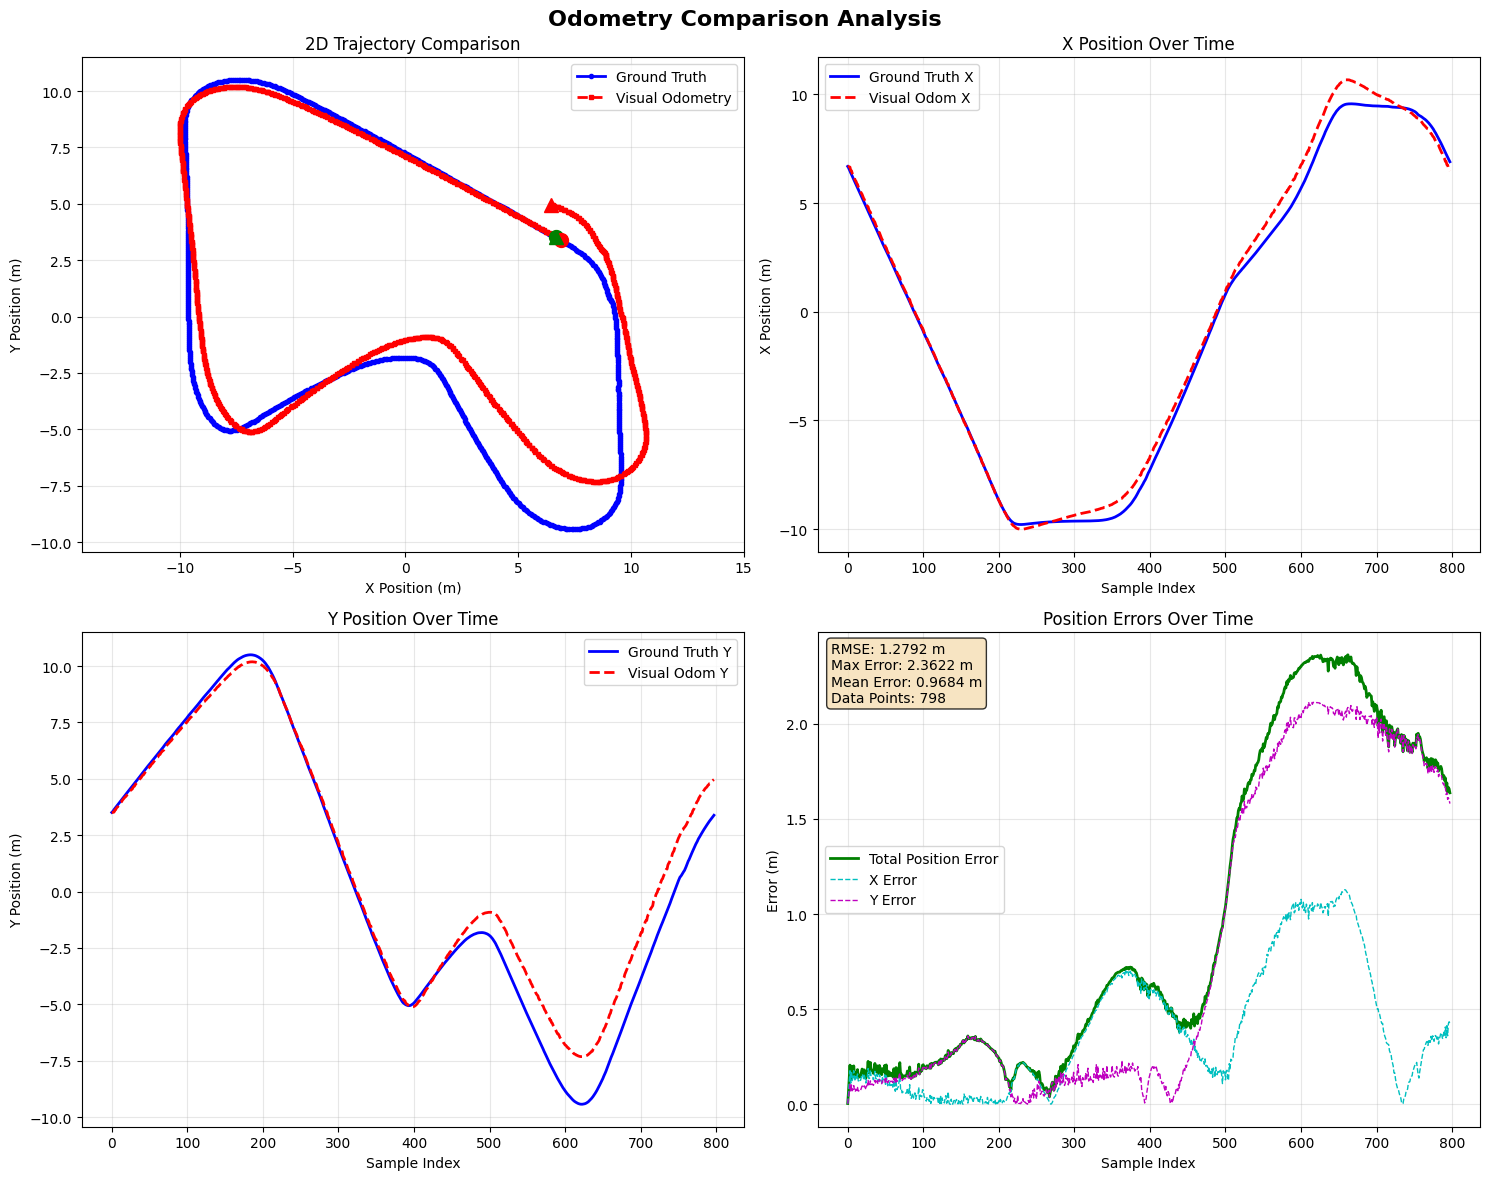

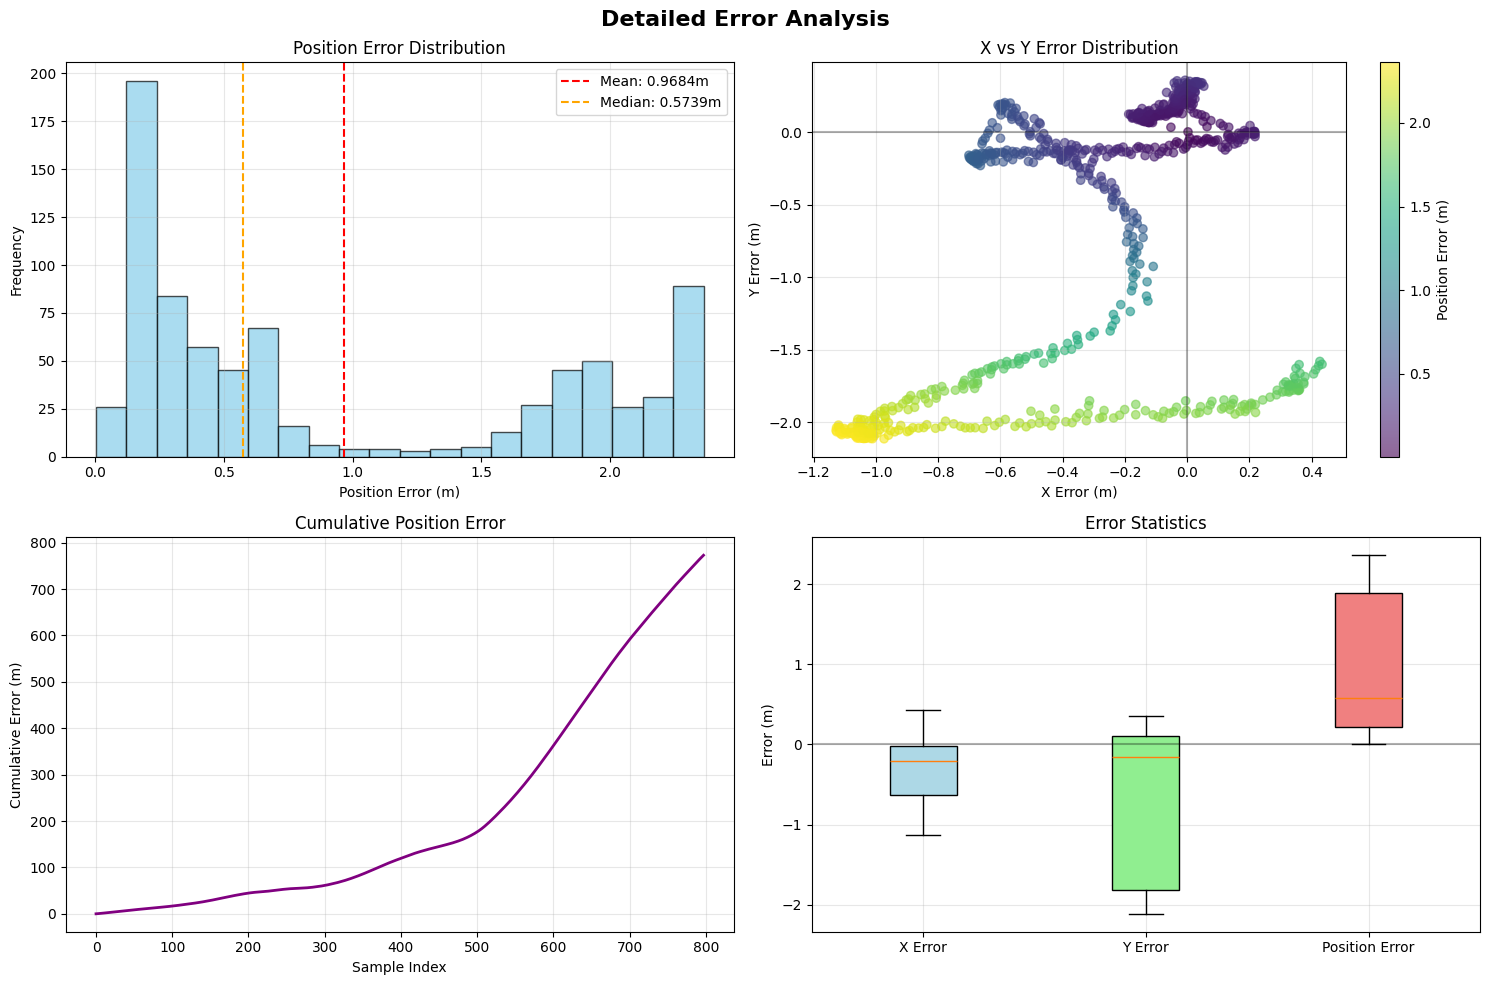

In [101]:
odom_1_0 = load_yaml('odom_1.0.yaml')
calculate_rmse(odom_1_0)
# plot_data_and_calcurate_error(odom_1_0)
plot_trajectories(odom_1_0['synchronized_data'])

### lowe ratio = 0.9

=== RMSE Analysis Results ===
Total data points: 806
RMSE: 1.3041 meters
Max error: 2.4107 meters
Min error: 0.0314 meters
Std deviation: 0.8569 meters
Mean GT distance: 8.8246 meters
Percentage error (RMSE/mean_dist): 14.78%
Mean individual percentage error: 13.19%


/tmp/ipykernel_196097/394932273.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(error_data, labels=labels, patch_artist=True)


Error creating trajectory plots: [Errno 2] No such file or directory: 'plots/error_analysis_20250528_180641.png'


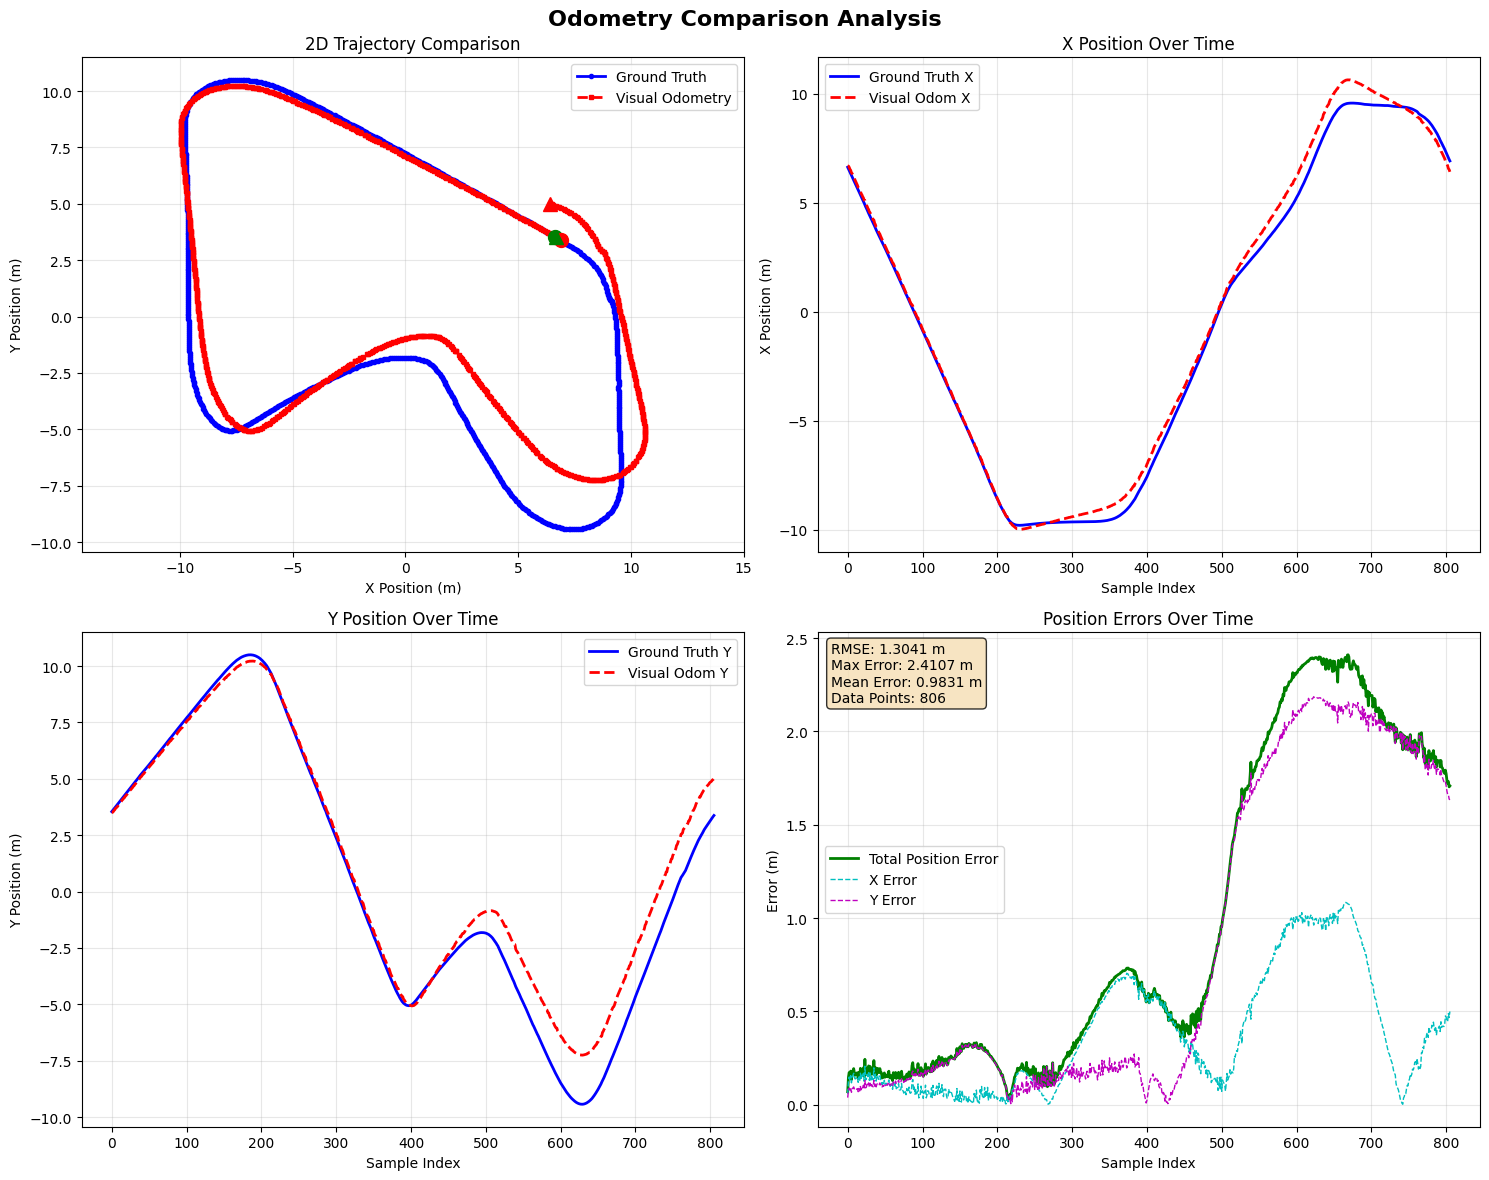

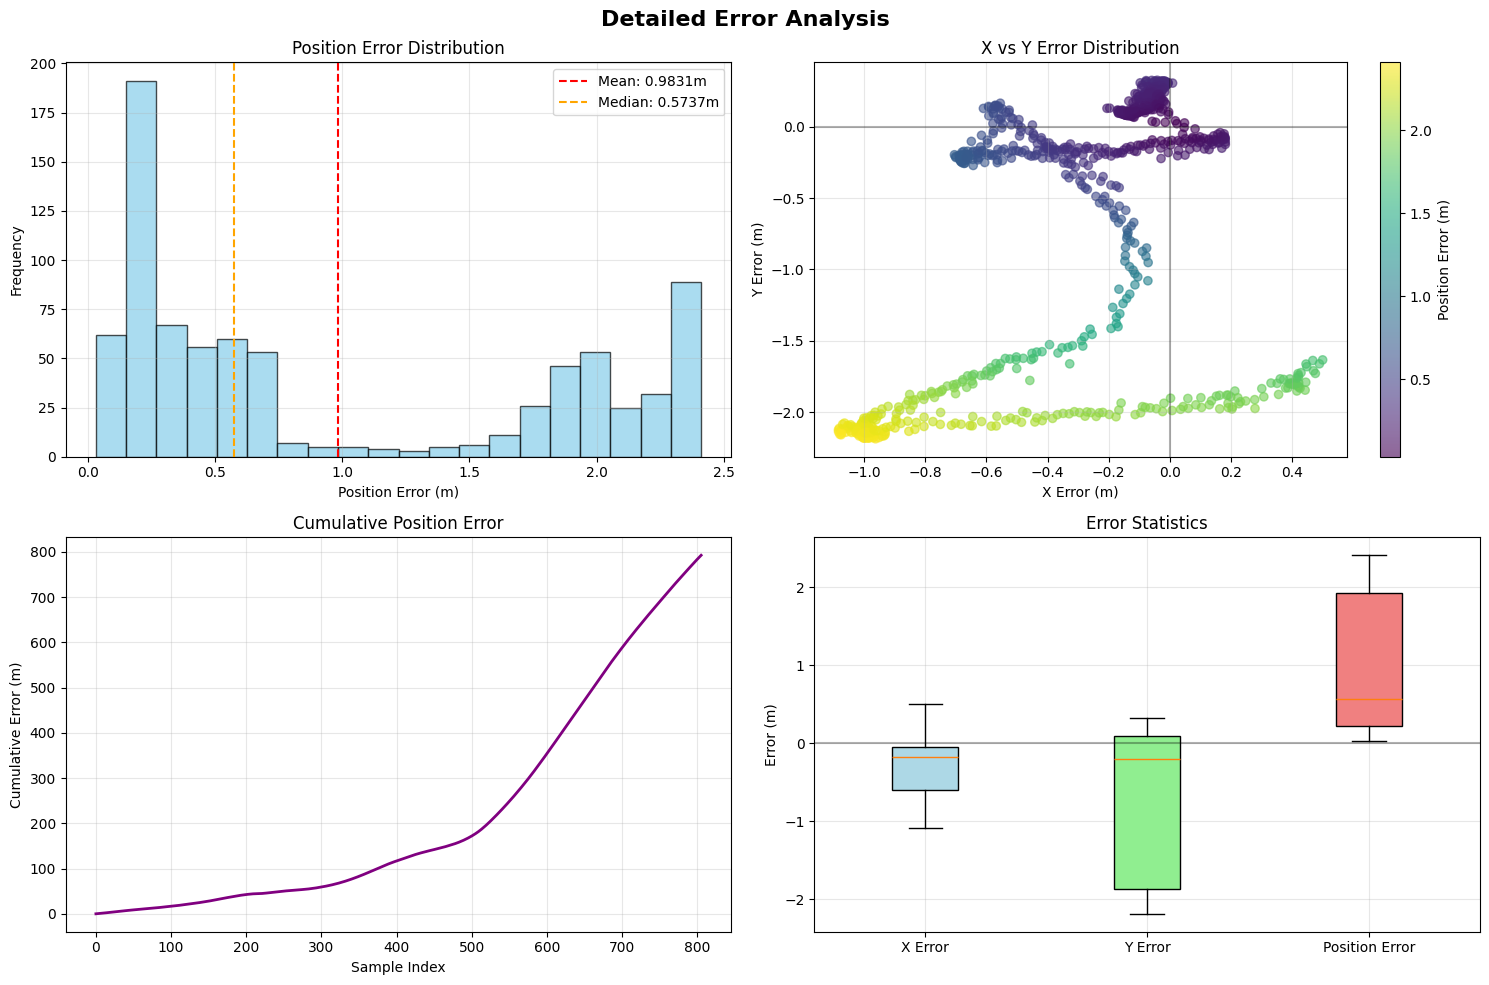

In [102]:
odom_0_9 = load_yaml('odom_0.9.yaml')
calculate_rmse(odom_0_9)
# plot_data_and_calcurate_error(odom_0_9)
plot_trajectories(odom_0_9['synchronized_data'])

### lowe ratio = 0.8

=== RMSE Analysis Results ===
Total data points: 760
RMSE: 1.2462 meters
Max error: 2.3503 meters
Min error: 0.0190 meters
Std deviation: 0.8227 meters
Mean GT distance: 8.8232 meters
Percentage error (RMSE/mean_dist): 14.12%
Mean individual percentage error: 12.36%


/tmp/ipykernel_196097/394932273.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(error_data, labels=labels, patch_artist=True)


Error creating trajectory plots: [Errno 2] No such file or directory: 'plots/error_analysis_20250528_180644.png'


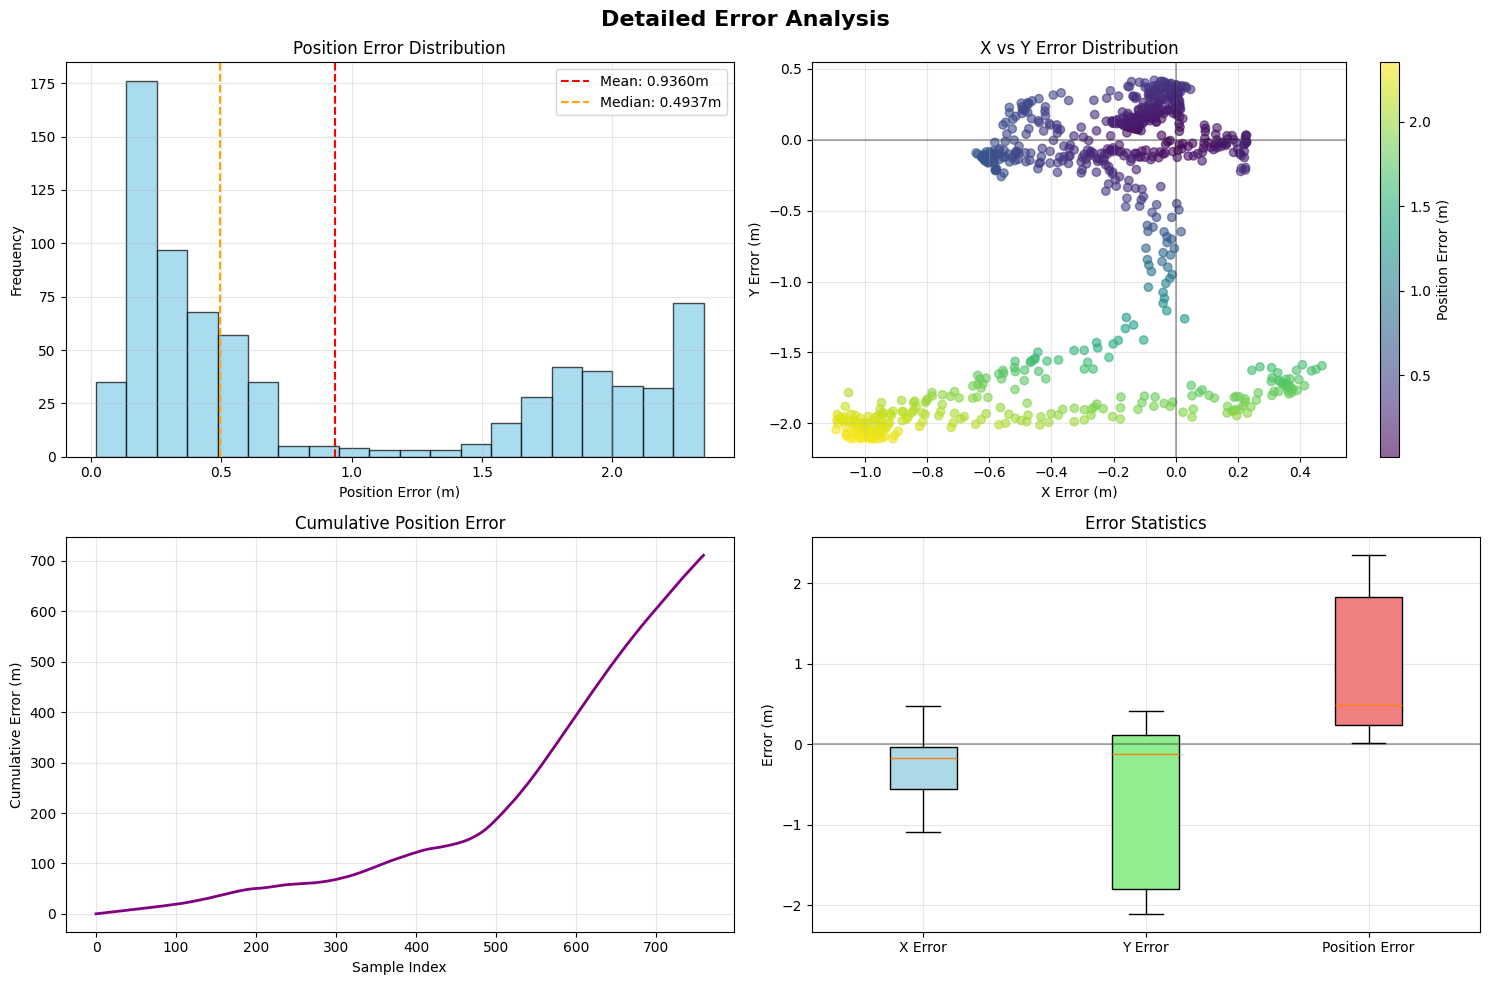

In [103]:
odom_0_8 = load_yaml('odom_0.8.yaml')
calculate_rmse(odom_0_8)
# plot_data_and_calcurate_error(odom_0_8)
plot_trajectories(odom_0_8['synchronized_data'])

### lowe ratio = 0.7

=== RMSE Analysis Results ===
Total data points: 799
RMSE: 1.2340 meters
Max error: 2.2903 meters
Min error: 0.0046 meters
Std deviation: 0.8070 meters
Mean GT distance: 8.8135 meters
Percentage error (RMSE/mean_dist): 14.00%
Mean individual percentage error: 12.35%


/tmp/ipykernel_196097/394932273.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(error_data, labels=labels, patch_artist=True)


Error creating trajectory plots: [Errno 2] No such file or directory: 'plots/error_analysis_20250528_193220.png'


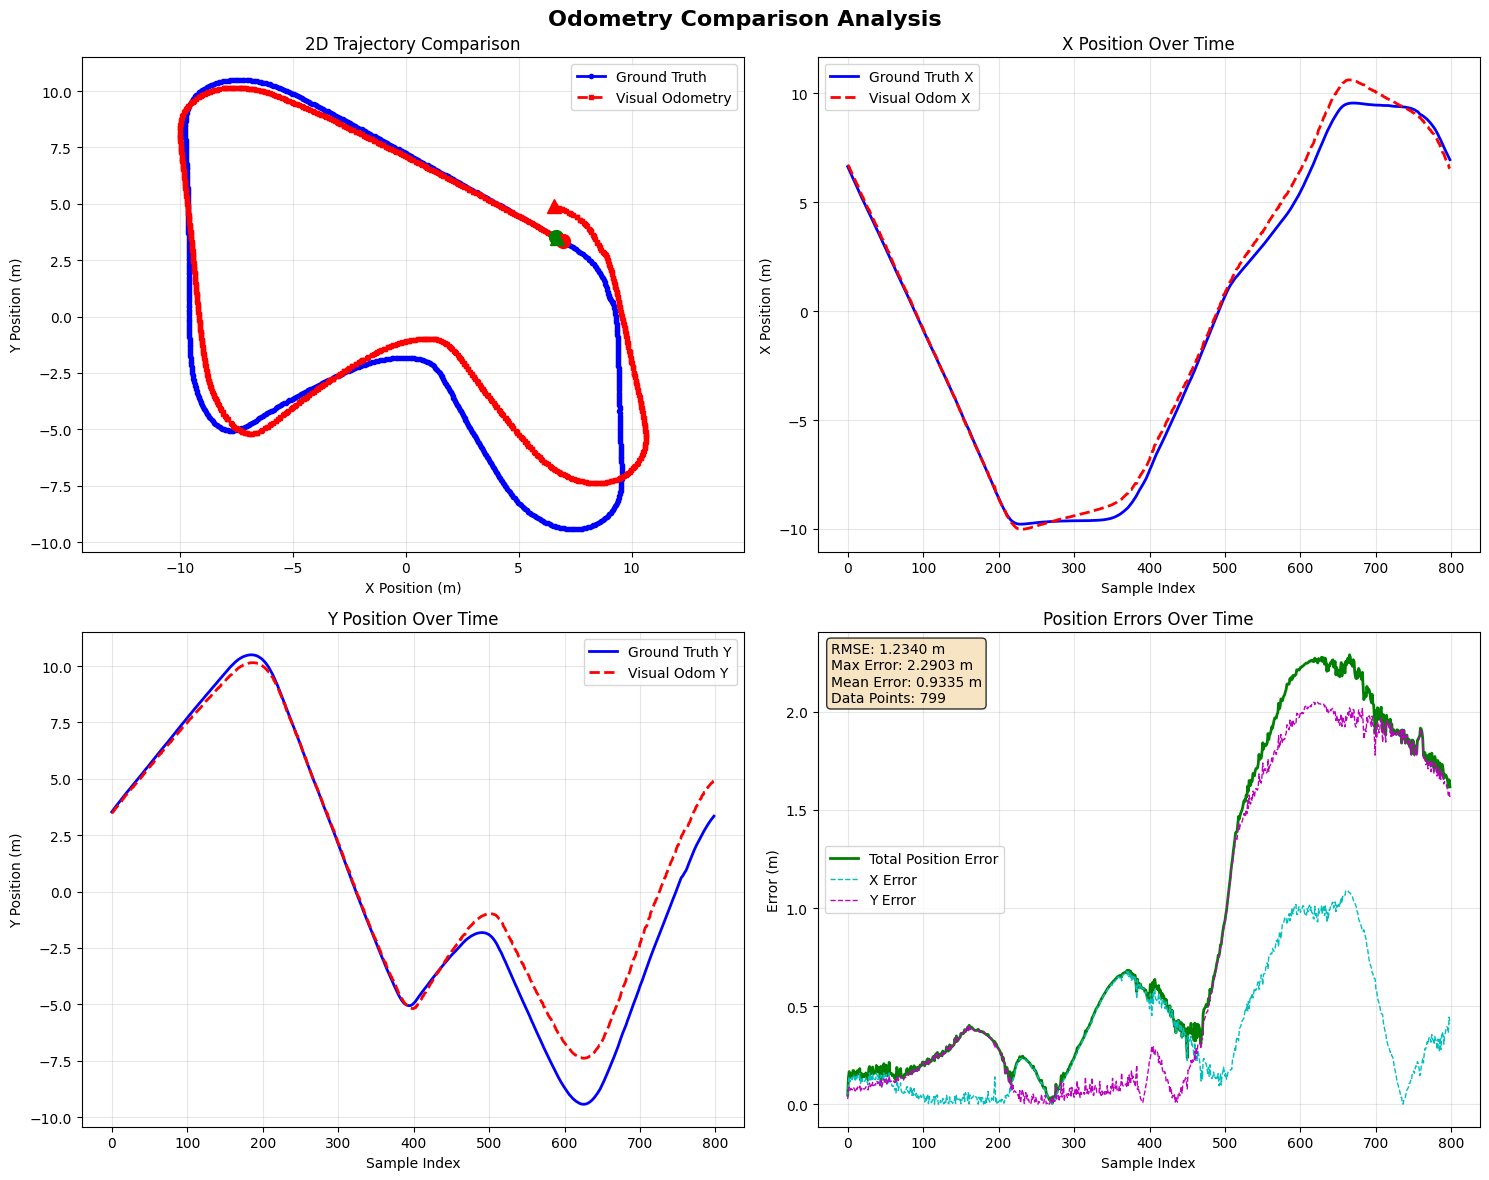

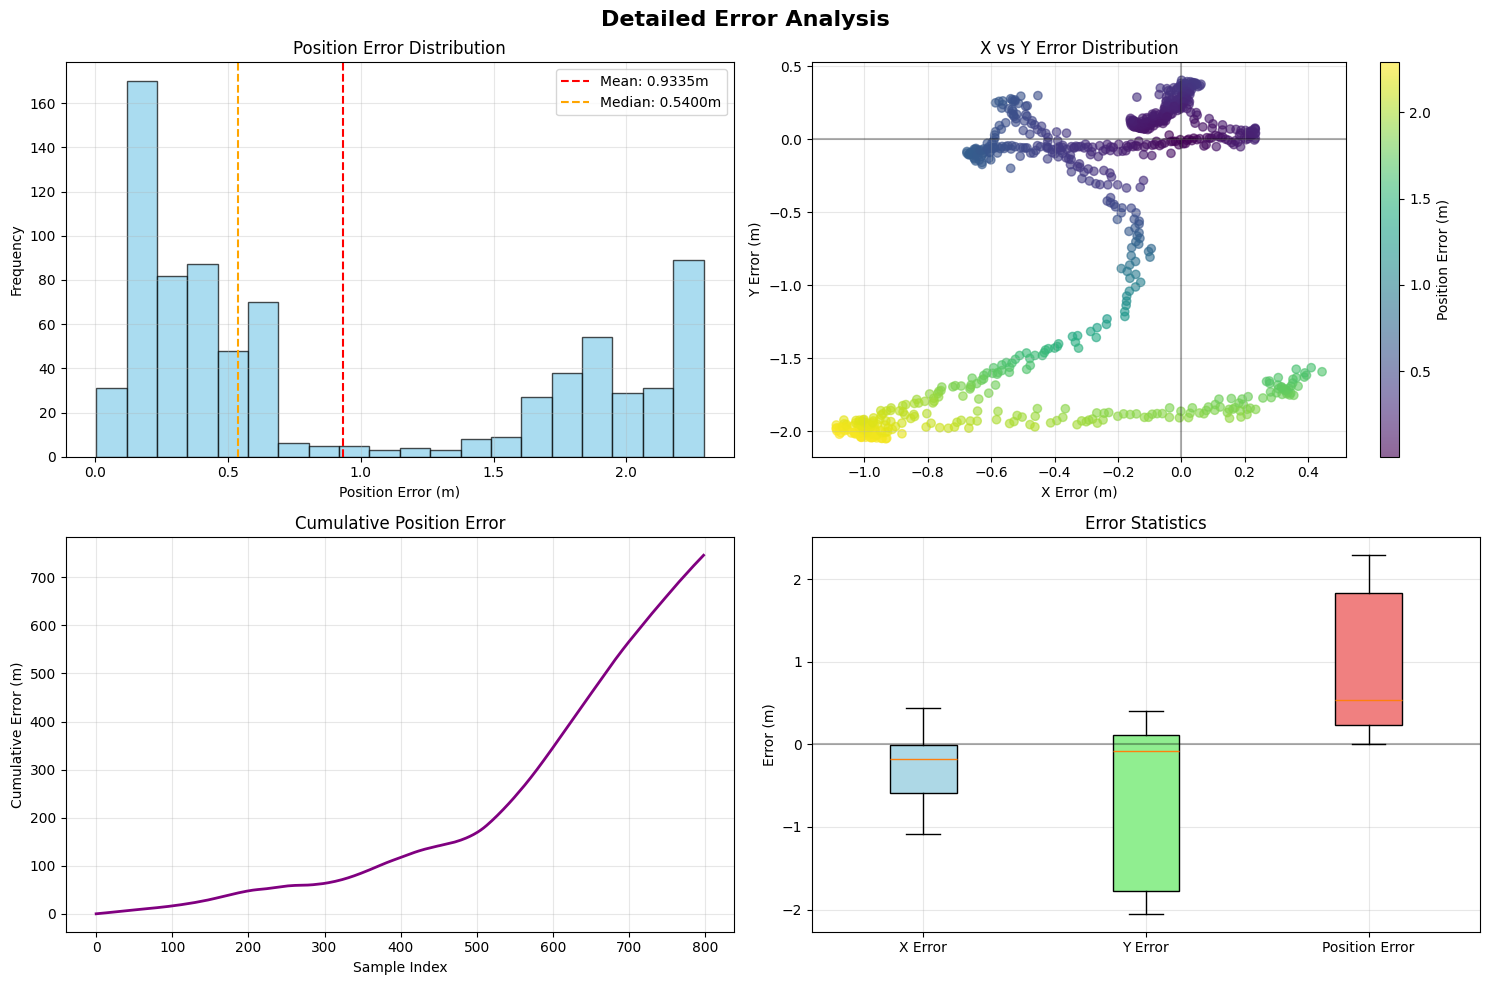

In [111]:
odom_0_7 = load_yaml('odom_0.7.yaml')
calculate_rmse(odom_0_7)
# plot_data_and_calcurate_error(odom_0_7)
plot_trajectories(odom_0_7['synchronized_data'])

### lowe ratio = 0.6.1

=== RMSE Analysis Results ===
Total data points: 818
RMSE: 1.3445 meters
Max error: 2.4906 meters
Min error: 0.0224 meters
Std deviation: 0.8890 meters
Mean GT distance: 8.8251 meters
Percentage error (RMSE/mean_dist): 15.23%
Mean individual percentage error: 13.39%


/tmp/ipykernel_196097/394932273.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(error_data, labels=labels, patch_artist=True)


Error creating trajectory plots: [Errno 2] No such file or directory: 'plots/error_analysis_20250528_192538.png'


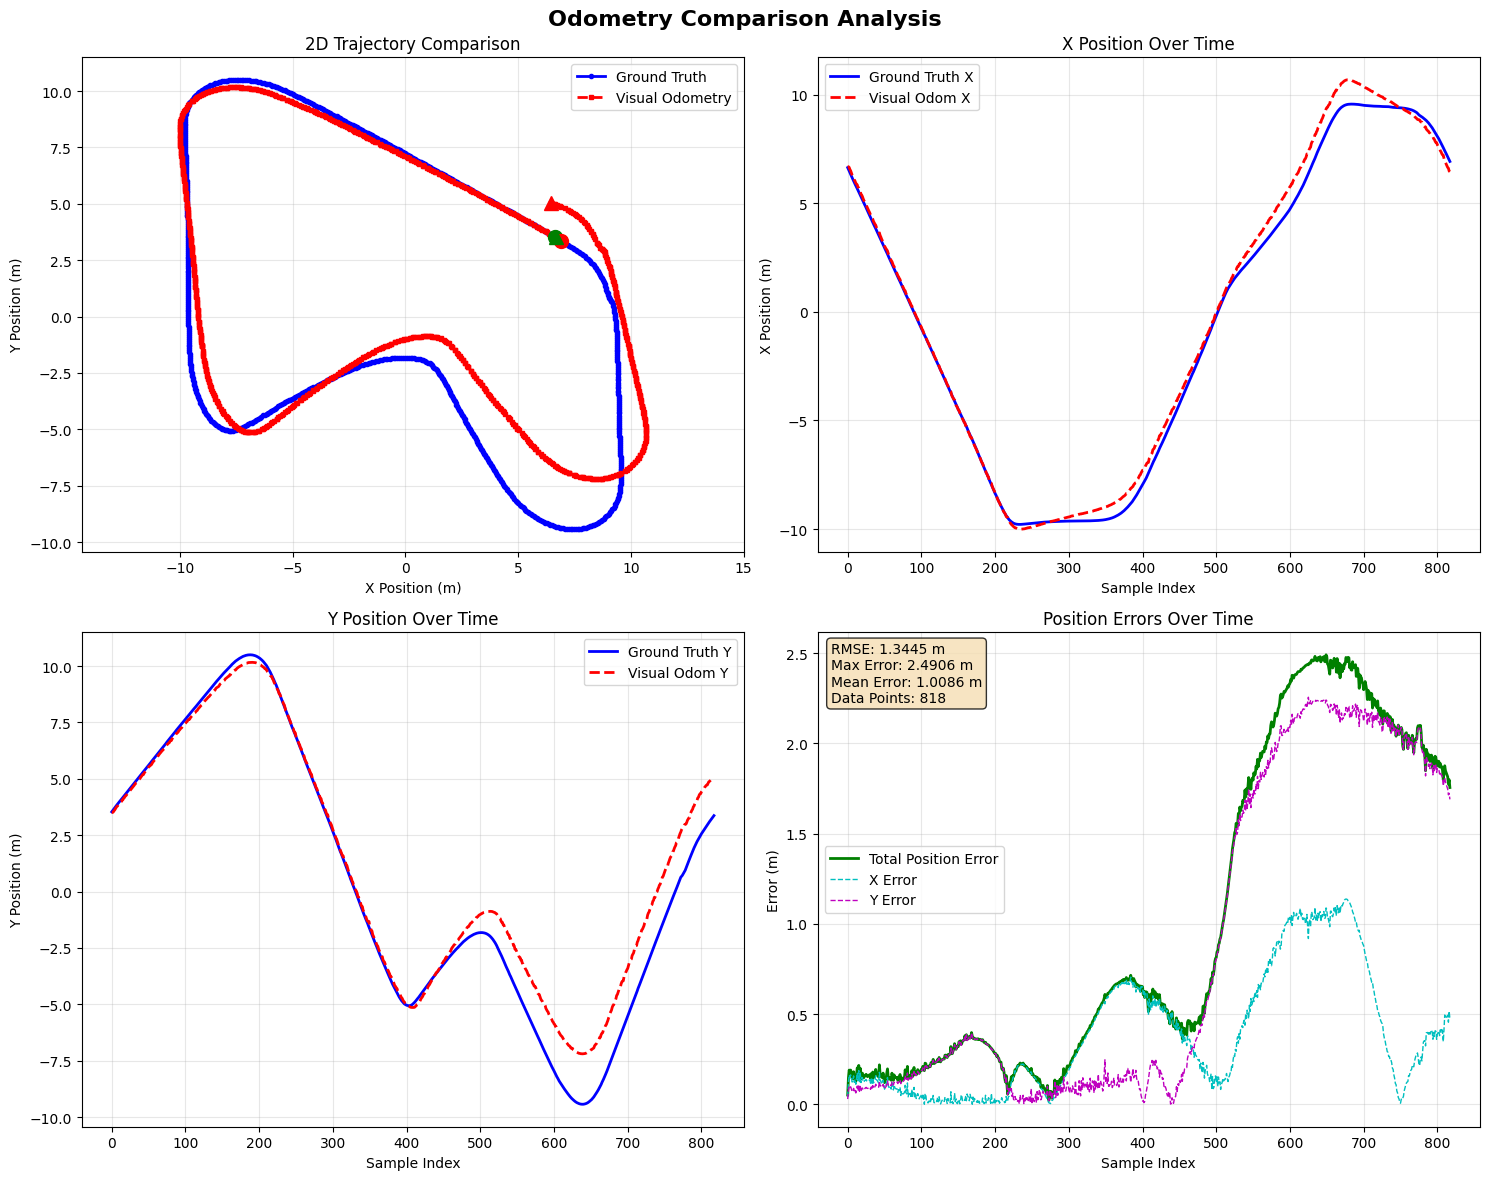

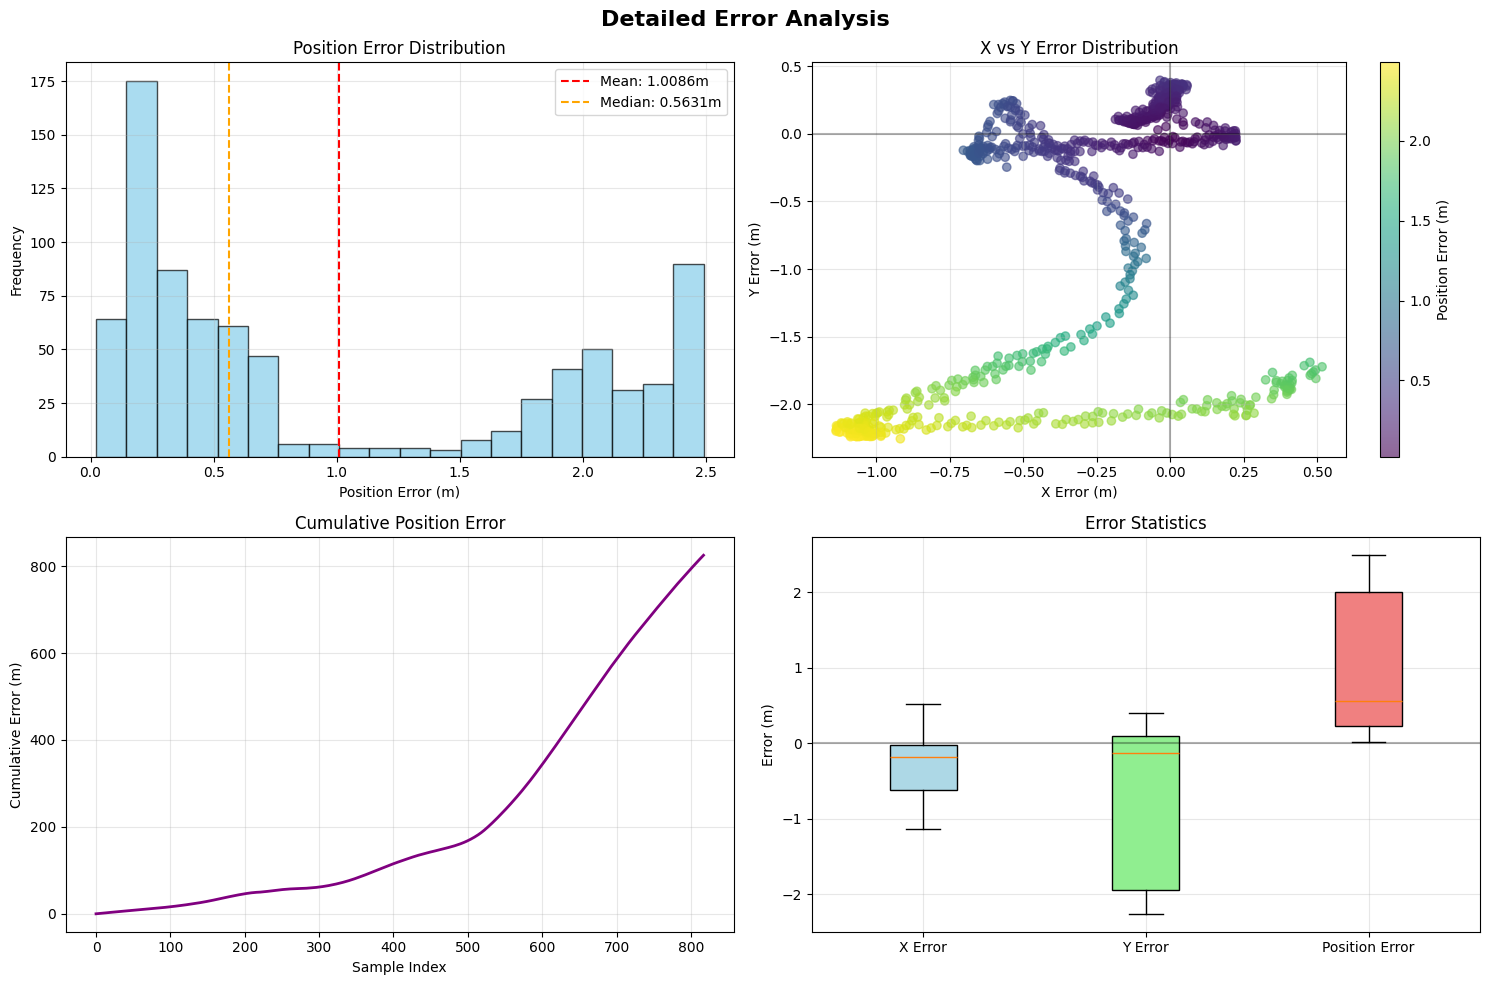

In [110]:
odom_0_6_1 = load_yaml('odom_0.6.1.yaml')
calculate_rmse(odom_0_6_1)
# plot_data_and_calcurate_error(odom_0_7)
plot_trajectories(odom_0_6_1['synchronized_data'])

### lowe ratio = 0.6

=== RMSE Analysis Results ===
Total data points: 811
RMSE: 1.2743 meters
Max error: 2.3658 meters
Min error: 0.0191 meters
Std deviation: 0.8437 meters
Mean GT distance: 8.8335 meters
Percentage error (RMSE/mean_dist): 14.43%
Mean individual percentage error: 12.63%


/tmp/ipykernel_196097/394932273.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(error_data, labels=labels, patch_artist=True)


Error creating trajectory plots: [Errno 2] No such file or directory: 'plots/error_analysis_20250528_182550.png'


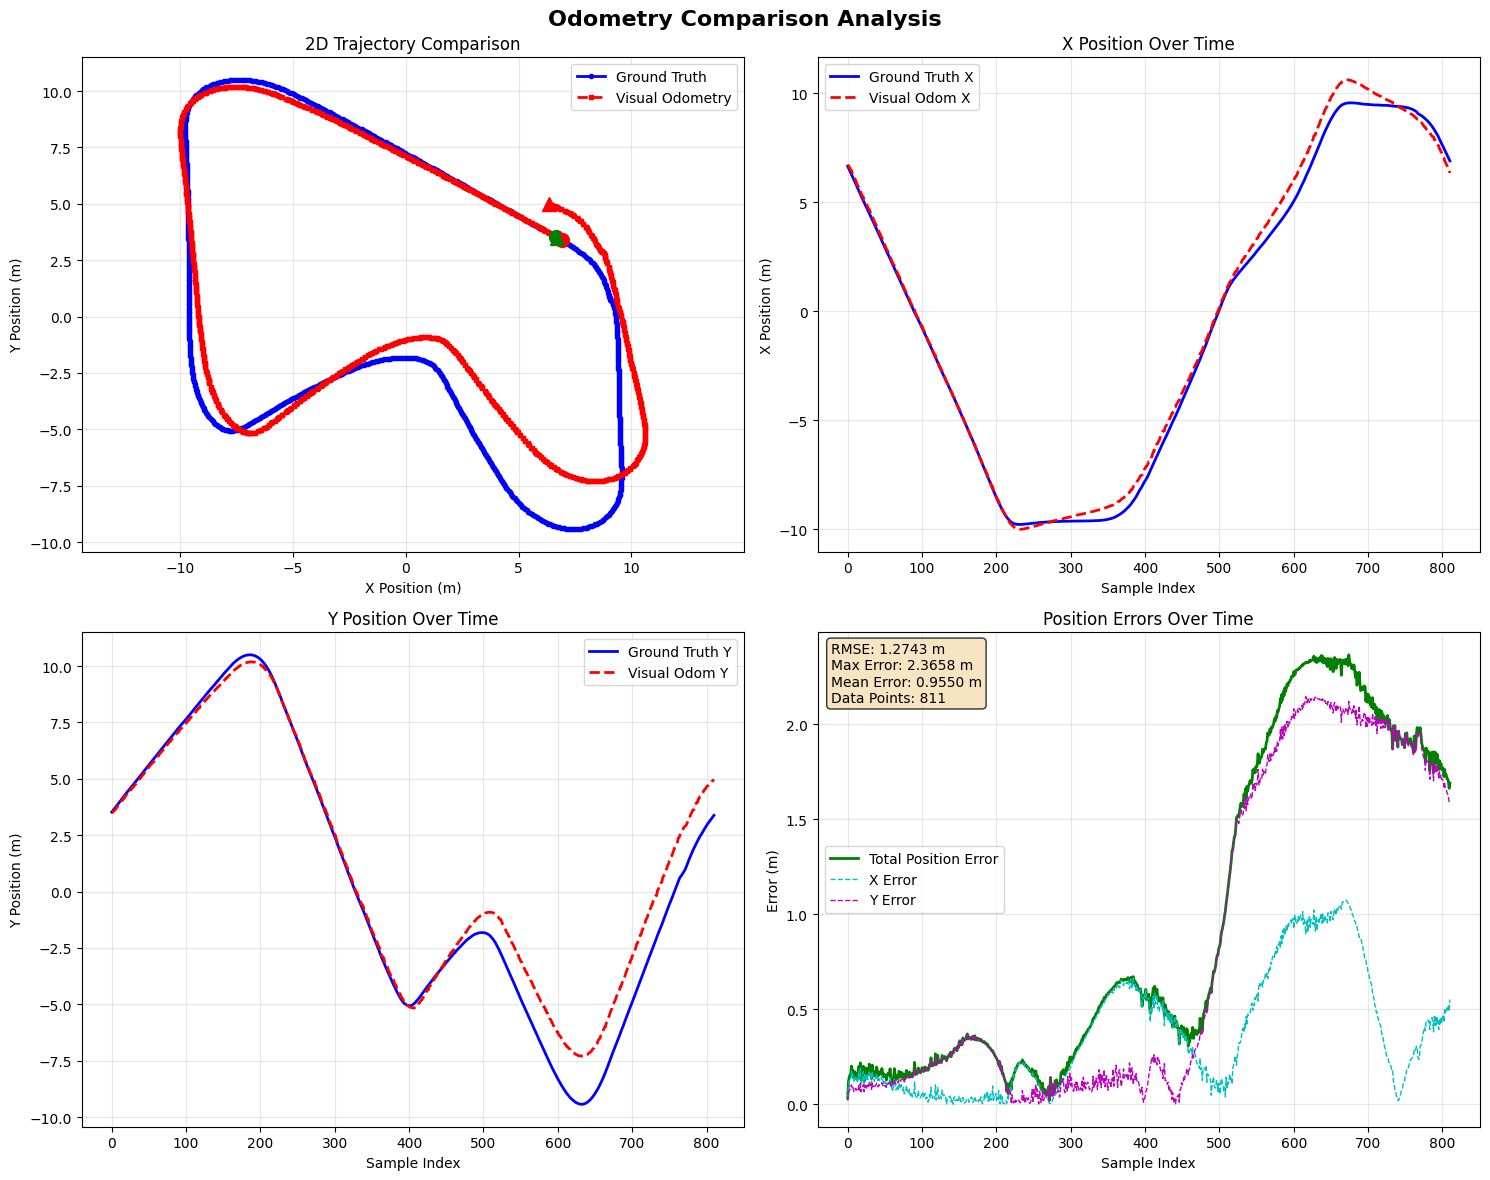

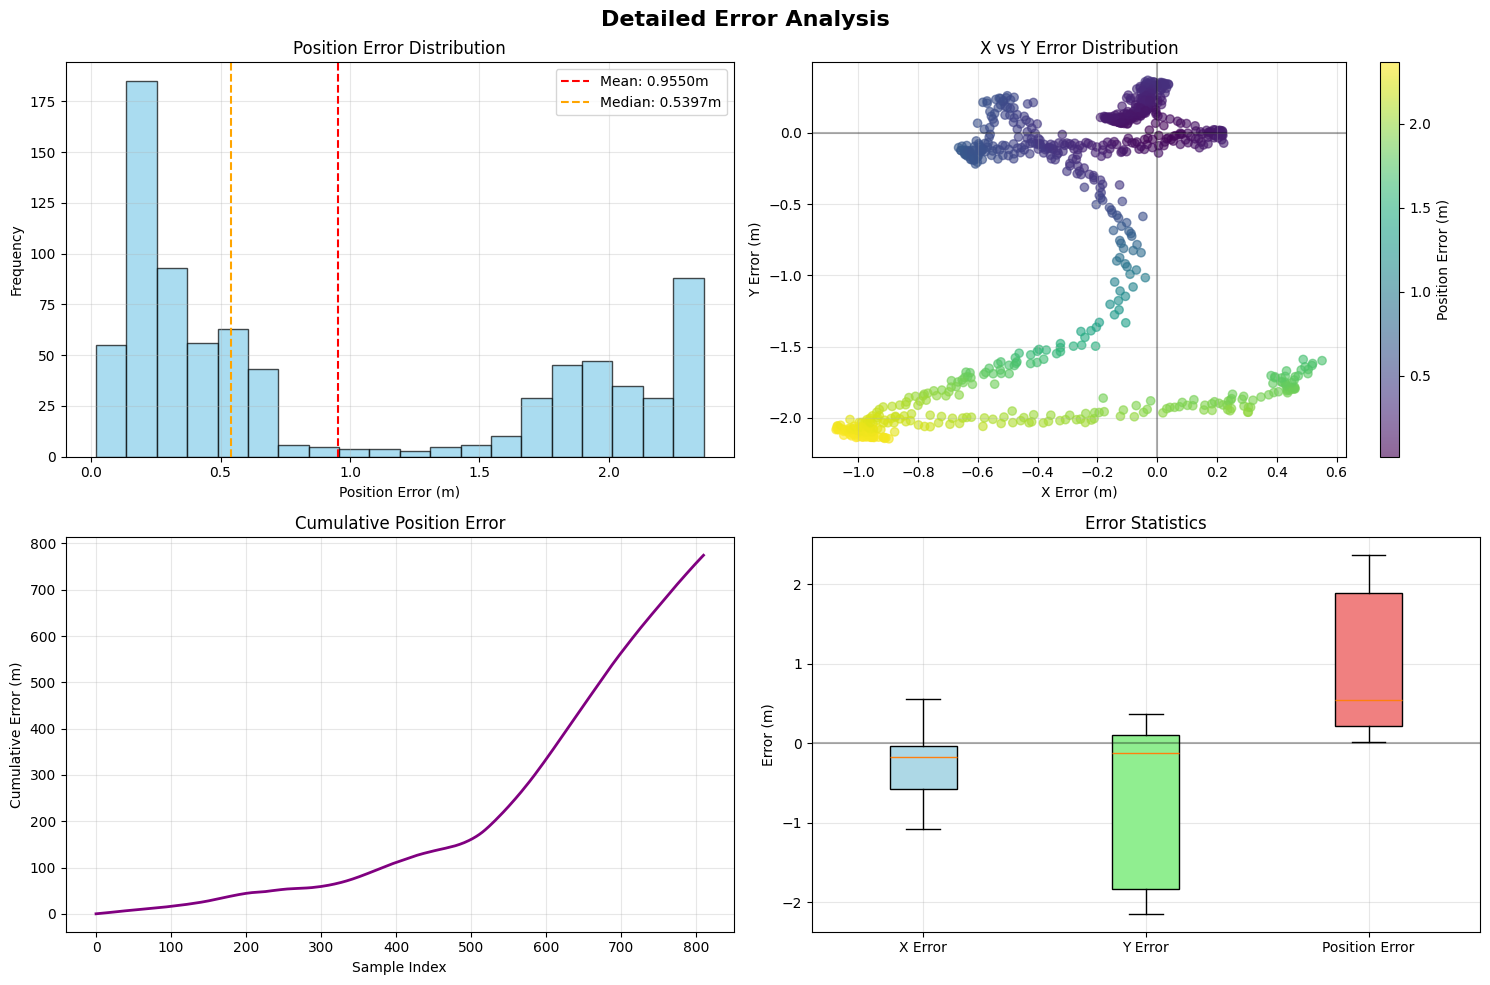

In [105]:
odom_0_6 = load_yaml('odom_0.6.yaml')
calculate_rmse(odom_0_6)
# plot_data_and_calcurate_error(odom_0_7)
plot_trajectories(odom_0_6['synchronized_data'])

### lowe ratio = 0.5

=== RMSE Analysis Results ===
Total data points: 815
RMSE: 1.2145 meters
Max error: 2.2523 meters
Min error: 0.0320 meters
Std deviation: 0.7862 meters
Mean GT distance: 8.8351 meters
Percentage error (RMSE/mean_dist): 13.75%
Mean individual percentage error: 12.26%


/tmp/ipykernel_196097/394932273.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(error_data, labels=labels, patch_artist=True)


Error creating trajectory plots: [Errno 2] No such file or directory: 'plots/error_analysis_20250528_183508.png'


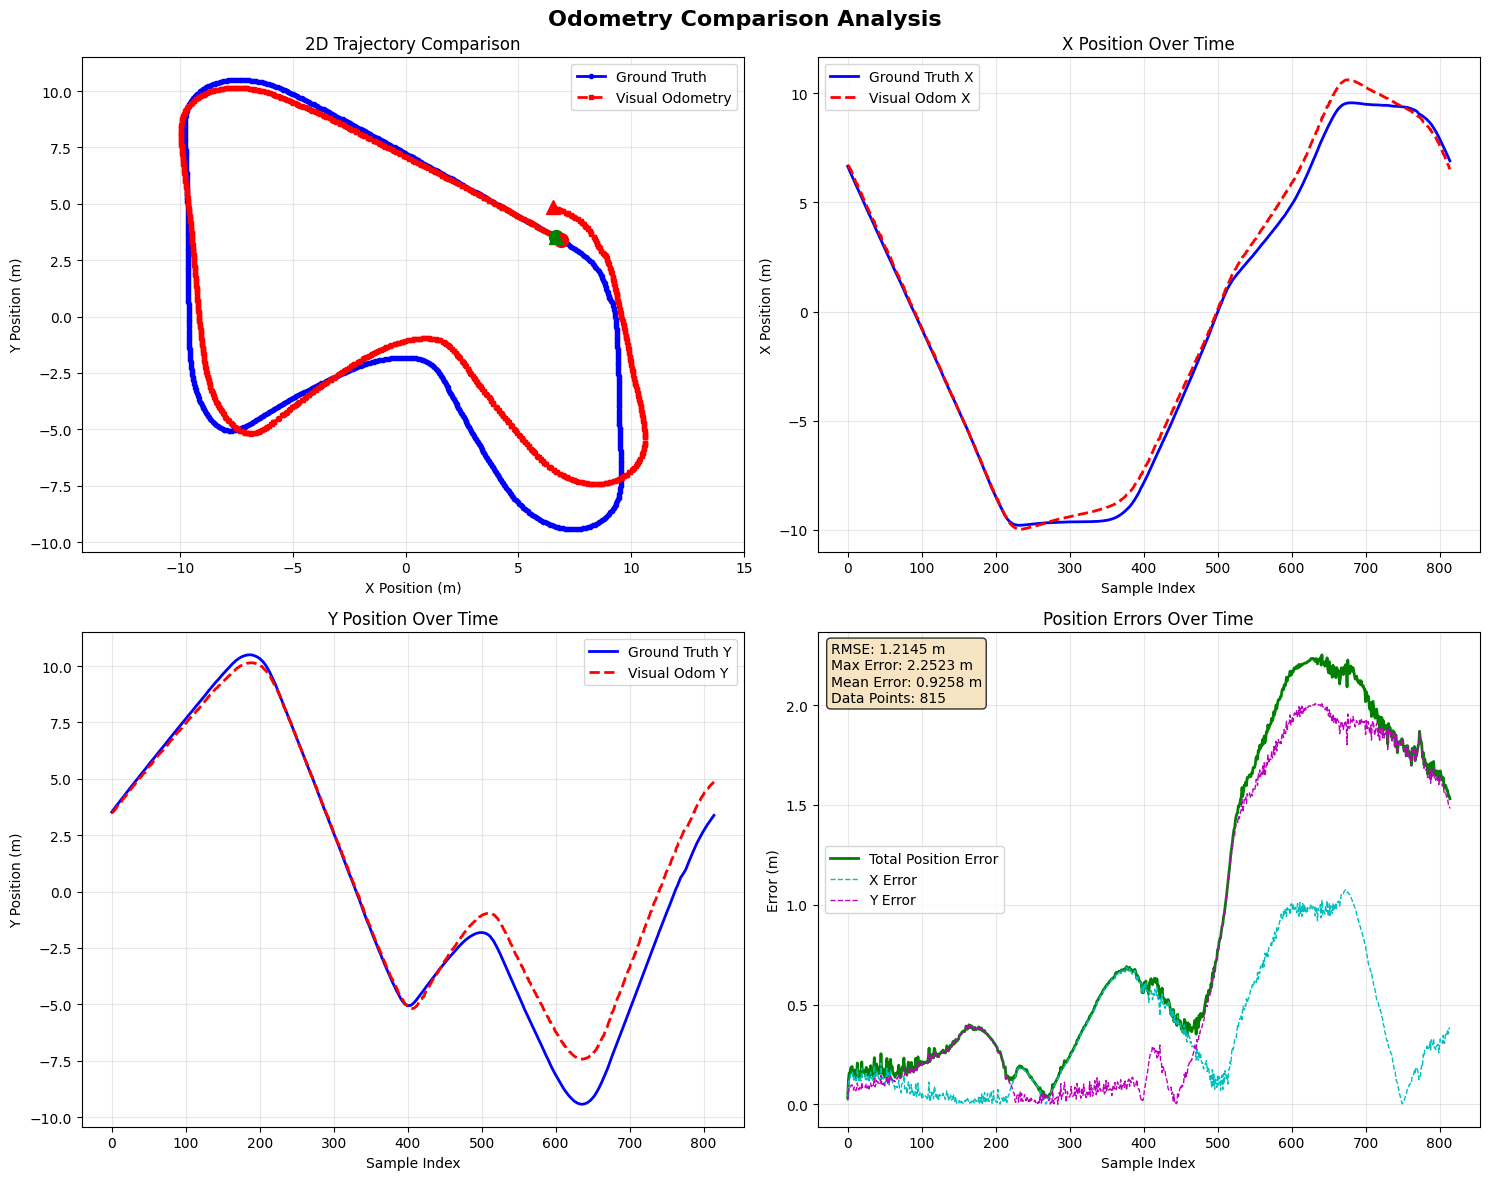

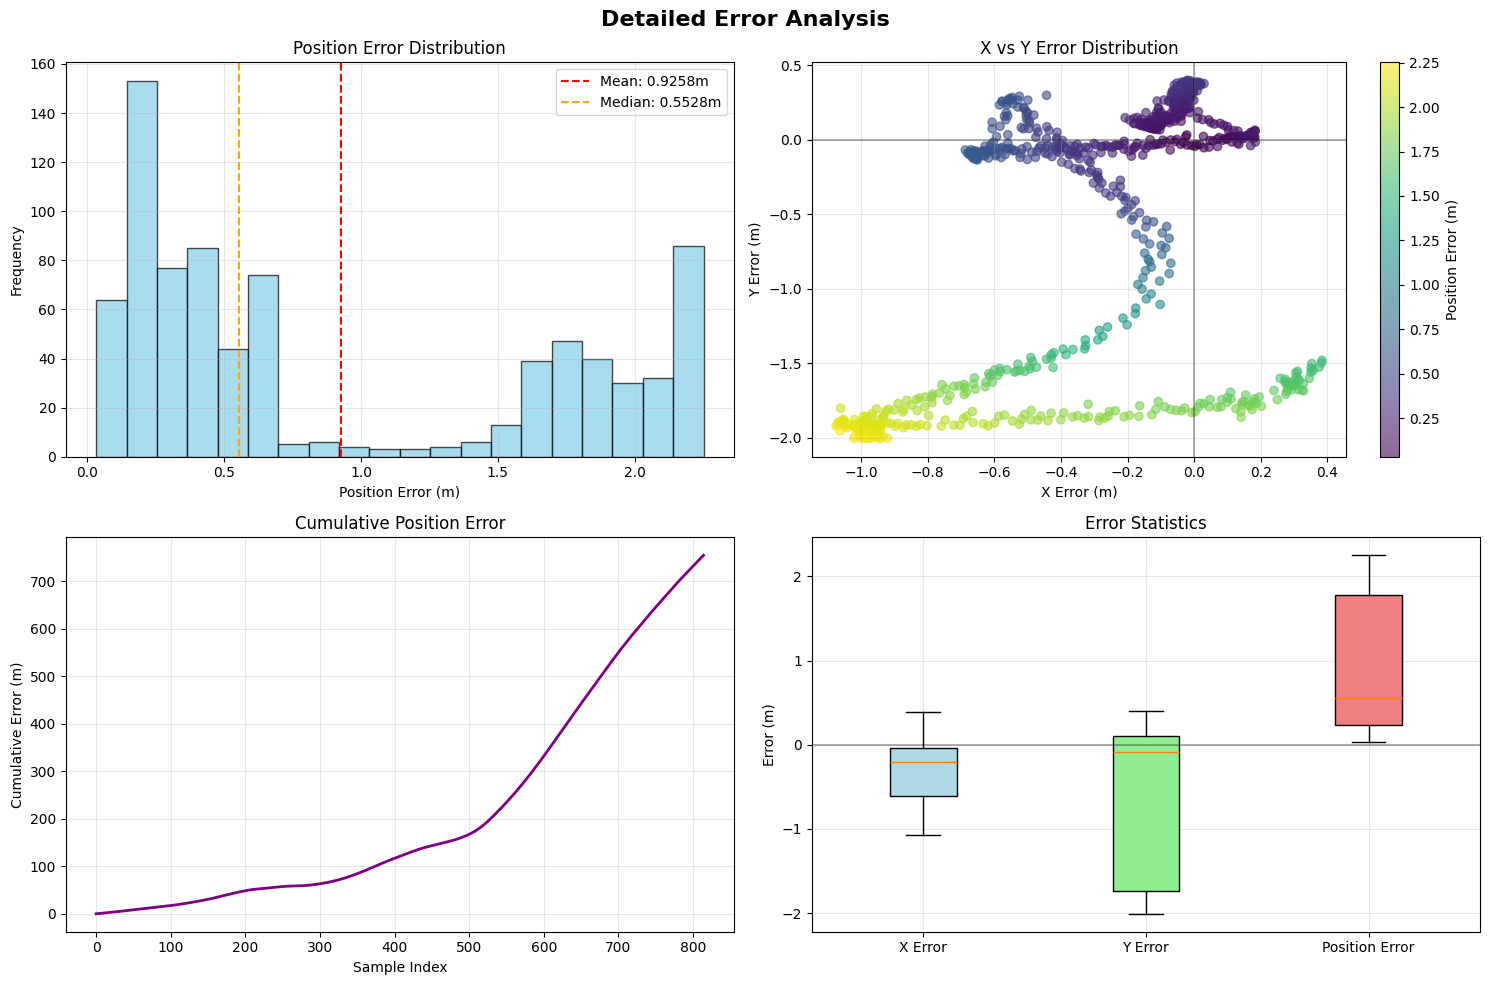

In [ ]:
odom_0_5 = load_yaml('odom_0.5.yaml')
calculate_rmse(odom_0_5)
# plot_data_and_calcurate_error(odom_0_7)
plot_trajectories(odom_0_5['synchronized_data'])

### lowe ratio = 0.4

=== RMSE Analysis Results ===
Total data points: 809
RMSE: 1.1122 meters
Max error: 2.0754 meters
Min error: 0.0425 meters
Std deviation: 0.7271 meters
Mean GT distance: 8.8236 meters
Percentage error (RMSE/mean_dist): 12.60%
Mean individual percentage error: 11.17%


/tmp/ipykernel_196097/394932273.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(error_data, labels=labels, patch_artist=True)


Error creating trajectory plots: [Errno 2] No such file or directory: 'plots/error_analysis_20250528_184528.png'


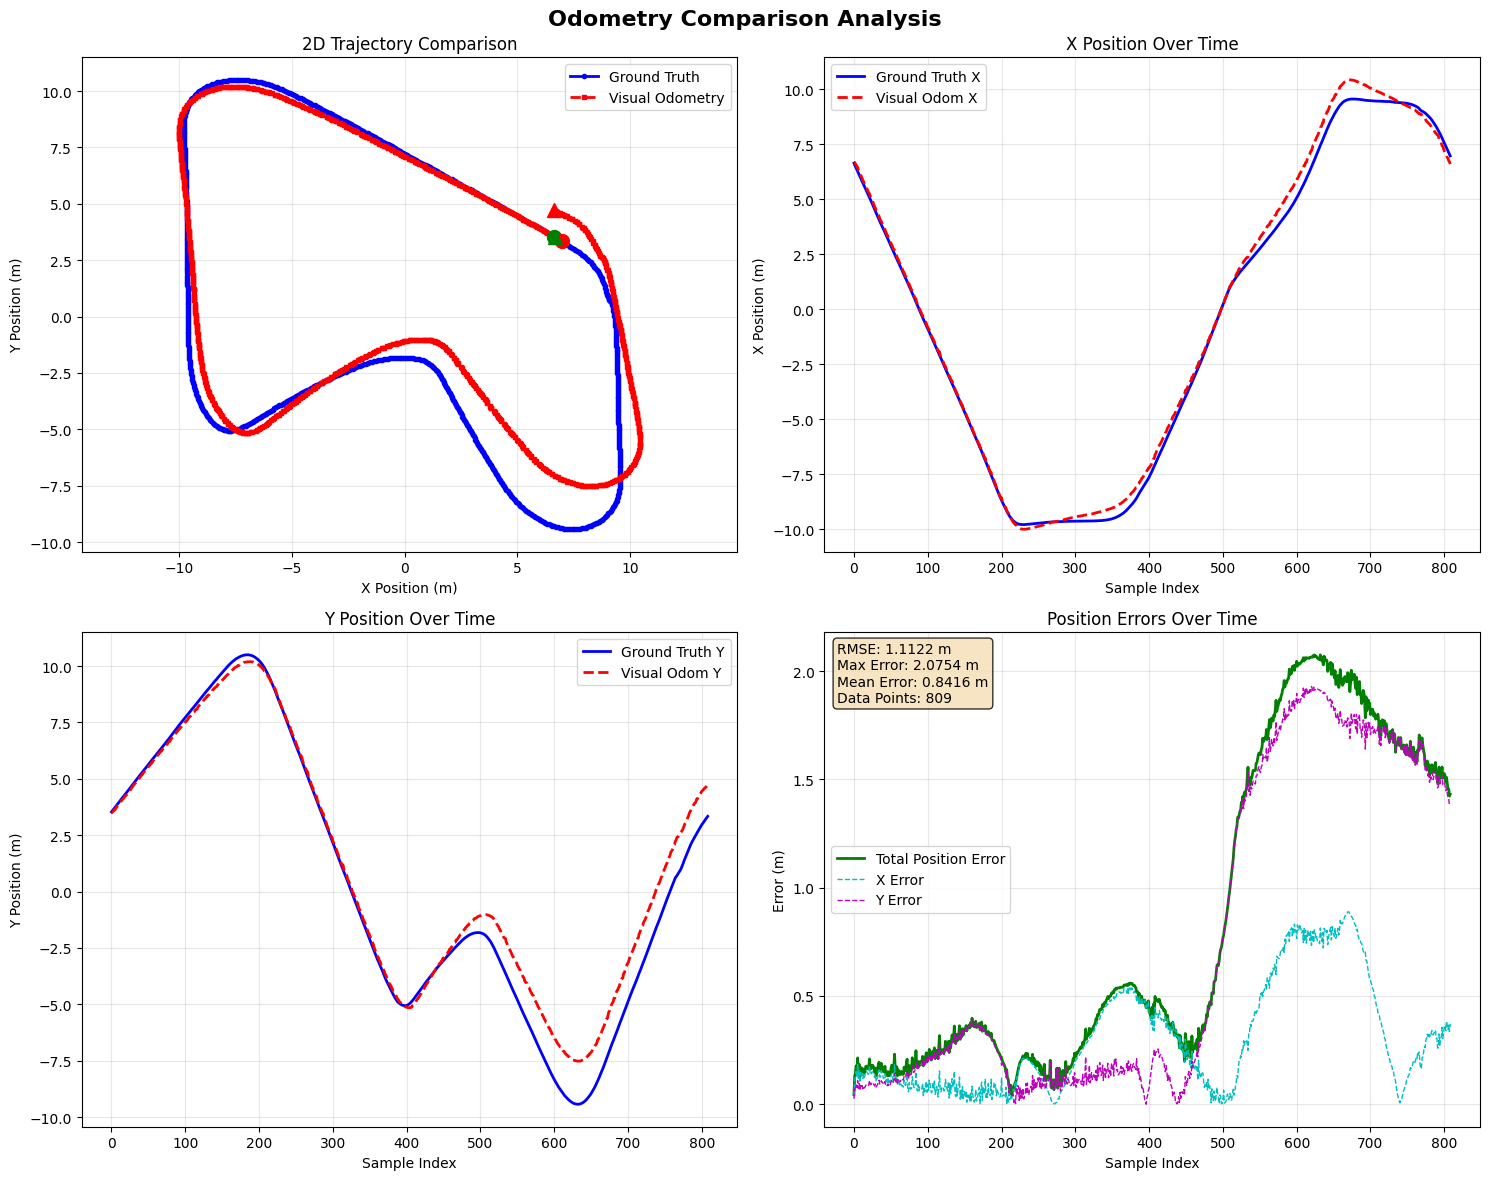

In [107]:
odom_0_4 = load_yaml('odom_0.4.yaml')
calculate_rmse(odom_0_4)
# plot_data_and_calcurate_error(odom_0_7)
plot_trajectories(odom_0_4['synchronized_data'])

### lowe ratio = 0.3

=== RMSE Analysis Results ===
Total data points: 810
RMSE: 0.4521 meters
Max error: 0.7203 meters
Min error: 0.0132 meters
Std deviation: 0.1875 meters
Mean GT distance: 8.8152 meters
Percentage error (RMSE/mean_dist): 5.13%
Mean individual percentage error: 5.73%


/tmp/ipykernel_196097/394932273.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1, 1].boxplot(error_data, labels=labels, patch_artist=True)


Error creating trajectory plots: [Errno 2] No such file or directory: 'plots/error_analysis_20250528_231701.png'


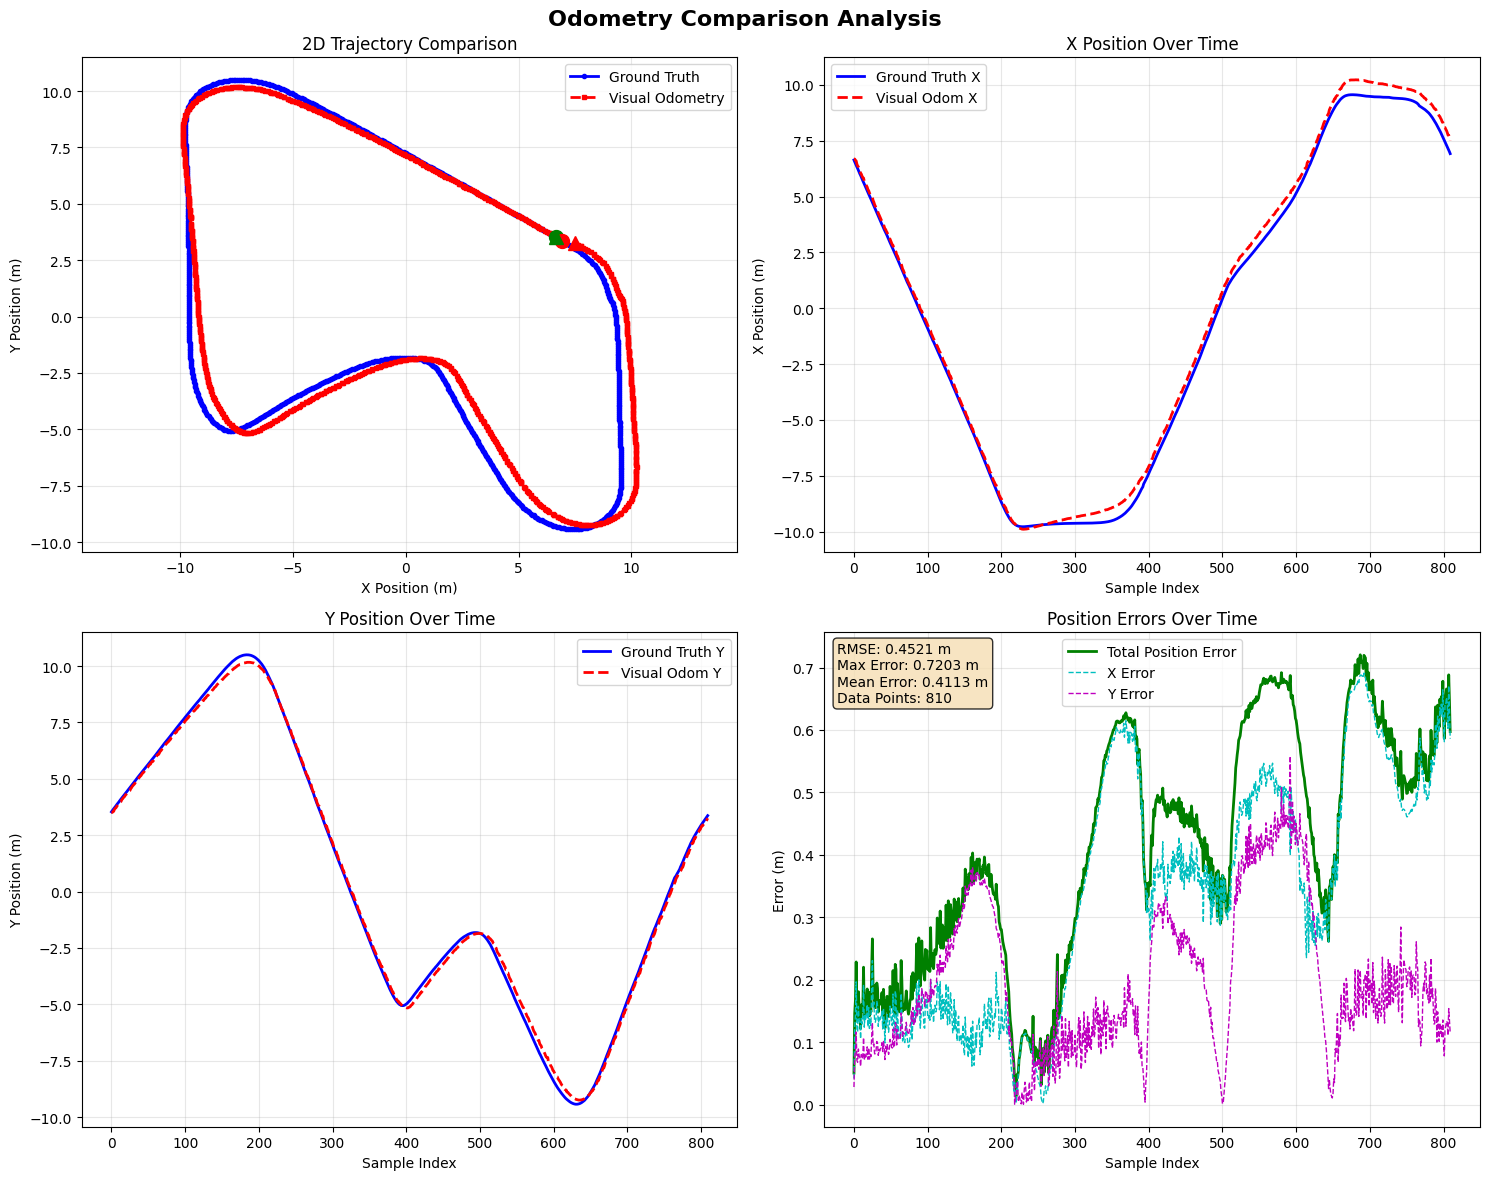

In [116]:
odom_0_3 = load_yaml('odom_0.3.yaml')
calculate_rmse(odom_0_3)
# plot_data_and_calcurate_error(odom_0_7)
plot_trajectories(odom_0_3['synchronized_data'])